<p style="text-align:right;">Daniel Böckenhoff, Max-Planck-Institute for Plasmaphysics</p>

## Neural Networks to recognise numbers with the MNIST database
The [MNIST](http://yann.lecun.com/exdb/mnist/) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
In this notebook we will perform image classification with shallow neural networks (NNs) on the basis of this data set.

**What you will learn:**
 - How to build data sets for [tensorflow](https://www.tensorflow.org/) (google machine learning api)
 - How to build neural networks with [keras](https://www.tensorflow.org/api_docs/python/tf/keras)
 - Monitoring training progress (callbacks)
 - Saving and reading a model to and from a file
 - Classification error analysis
 - Network architecture optimization
 
**Task:**
Carefully read the cells and execute them (Shift enter or menue panel). Complete the exercises marked as such.

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt

2024-10-29 11:47:59.044465: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 11:47:59.050645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 11:47:59.058793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 11:47:59.061019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 11:47:59.067525: I tensorflow/core/platform/cpu_feature_guar

## Image Data Preparation
We will load the mnist data set with the *keras.datasets* backend.

In [2]:
# Set the path to the directory where we have already downloaded the data
data_path = (pathlib.Path(".") / "..").resolve() / 'data' / 'mnist.npz'  # if no path were given, keras would download the dataset

# Load the data
data = np.load(data_path)
x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']

class_names = list(set(y_train))
num_classes = len(class_names)  # 10
num_imgs = len(y_train) + len(y_test)

print(f"Number of samples in the whole data set: {num_imgs}")

Number of samples in the whole data set: 70000


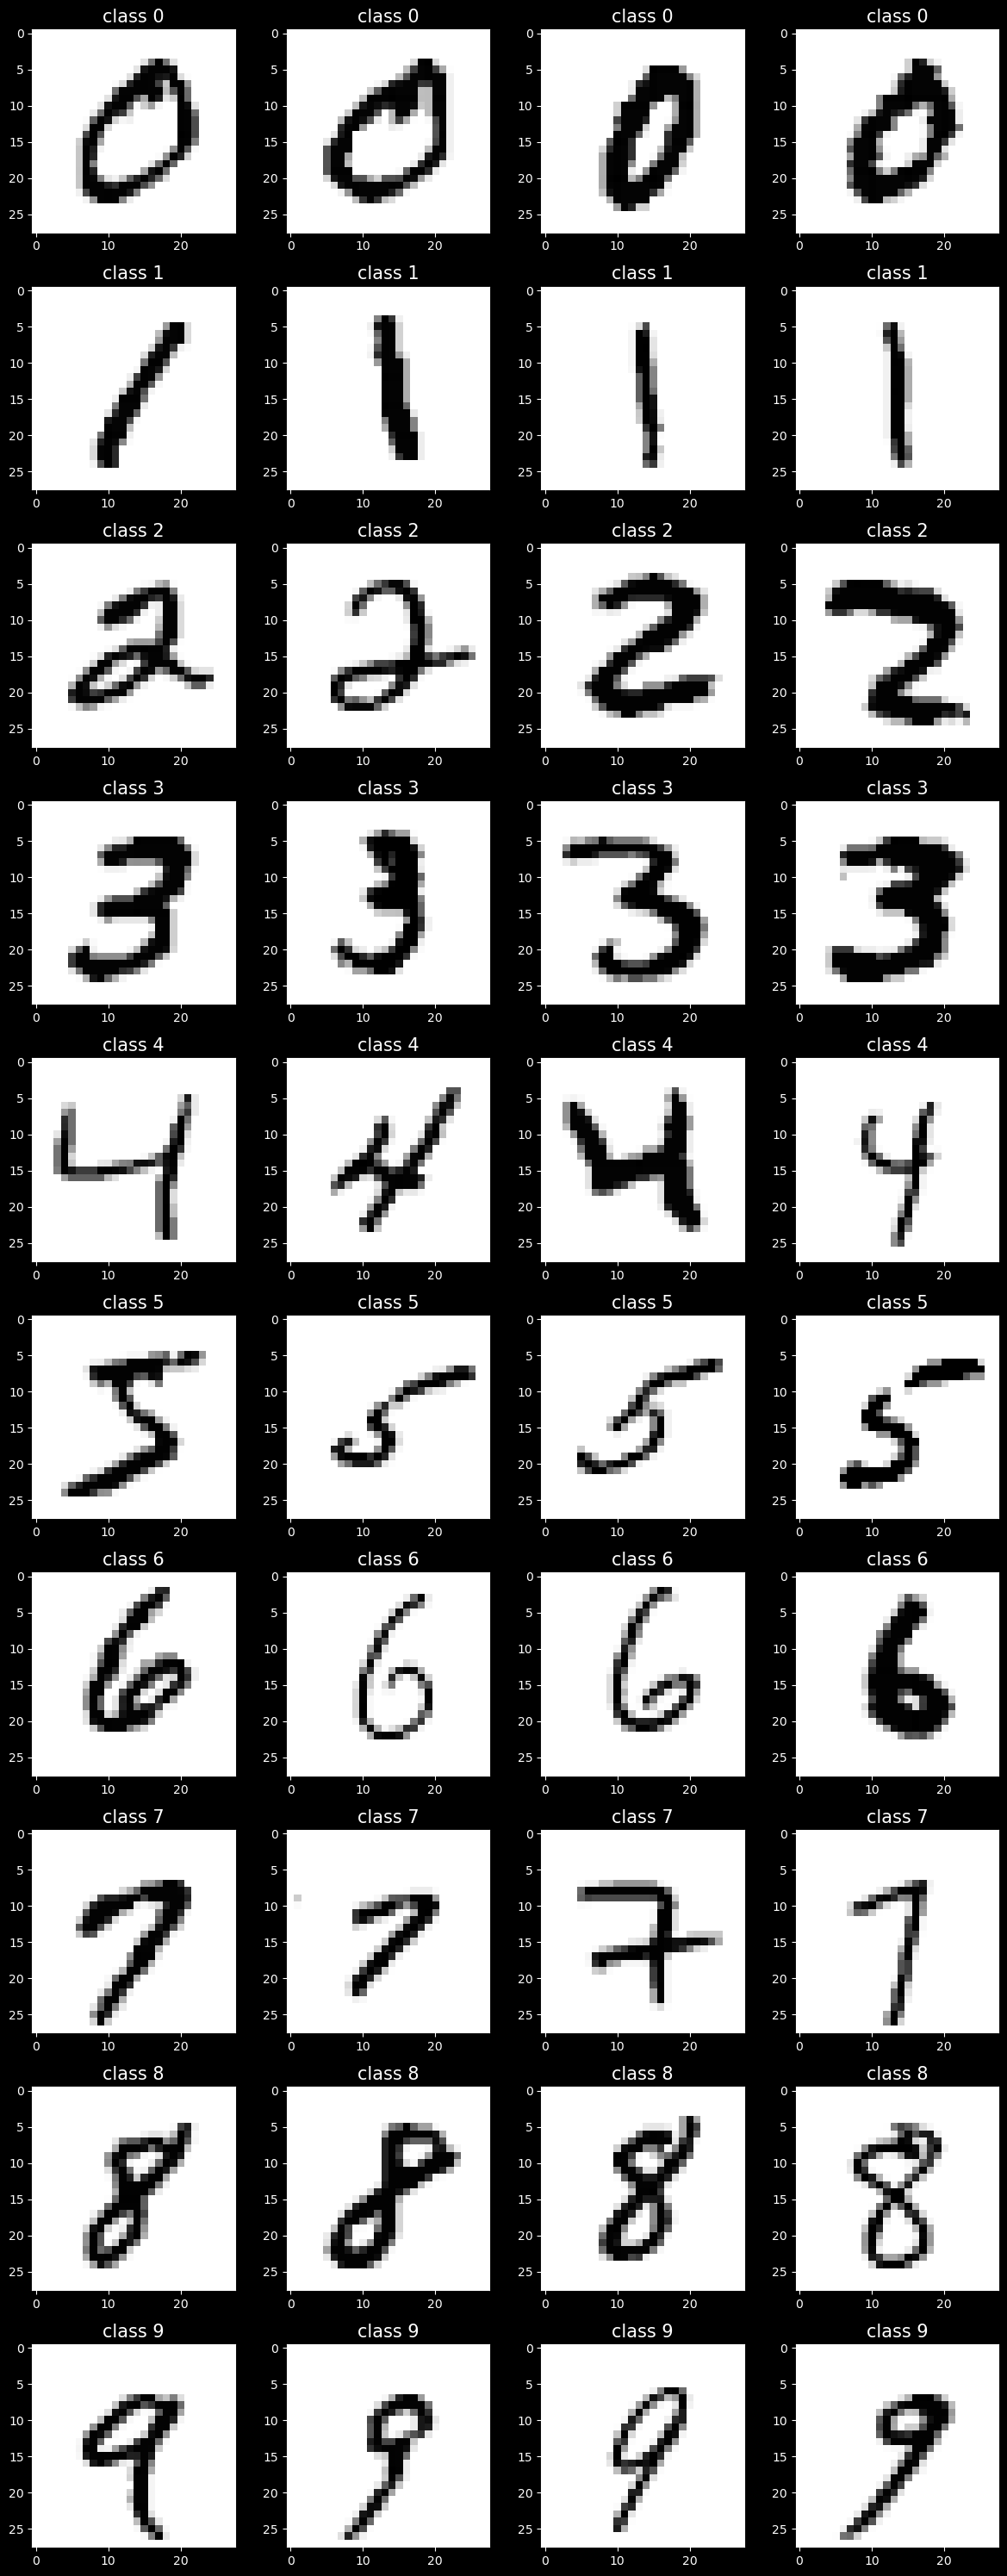

In [3]:
# Plot a few sample images for each class
num_examples_per_class = 4
_, ax = plt.subplots(nrows = num_classes, ncols = num_examples_per_class,
                     figsize = (3 * num_examples_per_class, 3 * num_classes)) # adjust size here
    
for i in range(num_classes): # loop over classes = rows
    indices = np.where(y_train == i)
    for j, img in enumerate(x_train[indices][:num_examples_per_class]):
        ax[i, j].imshow(img, cmap='Greys')
        ax[i, j].set_title("class " + str(i), fontsize=15)  
plt.tight_layout()
plt.show()

## Make TensorFlow Datasets


**Note:** Training, Validation and Test Split
A rule of thum is to split the data set in taining, validation and test set by the ratio 80:10:10.
A specialty in the mnist dataset is the predefined test set which serves the purpose of exact comparability between different research groups.

NNs cannot work with letter sequences directly so we have to think about how to encode the sequences (and our labels) into numerical form.
### One hot encoding
A popular method for encdoding categorical features that avoids an implicit order is "one hot encoding" (implemented with keras.utils.to_categorical).

In [4]:
assert x_train.shape[1] == x_train.shape[2], "Expected square image"
img_size = x_train.shape[1]  # width and height of all images

# Convert target classes to categorical ones
y_train_labels = y_train
y_test_labels = y_test
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Let us inspect what to_categorical did:
for i in range(10):
    print("Target label: {}, One hot encoded Target Vector: {}"
          .format(y_train_labels[i], y_train[i]))

Target label: 5, One hot encoded Target Vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Target label: 0, One hot encoded Target Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 4, One hot encoded Target Vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Target label: 1, One hot encoded Target Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 9, One hot encoded Target Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Target label: 2, One hot encoded Target Vector: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Target label: 1, One hot encoded Target Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 3, One hot encoded Target Vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Target label: 1, One hot encoded Target Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 4, One hot encoded Target Vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# Performance benchmarks
**Exercise:**
1. Before we build a machine learning model to solve the task properly, lets first determine the performance of two naive benchmarks. What $$\text{Accuracy} = \frac{\text{#correctly classified training data}}{\text{#evaluated training data}}$$ would you expect ...
    1. ... for a random output generator (assigning images to random classes)?
    2. ... for a naive algorithm which works without seeing any picture but knows about the number of samples per class. What would this "algorithm" predict?

In [5]:
# Your code here for Exercise 1.B
# ...

In [6]:
# 1.2) 
# percentages for the relative frequencies of each class
print("Class\t\tSamples [%]\n")
for i in range(num_classes):
    print("{0}\t\t{1}".format(i, 100 * np.sum(y_train[:, i]) / len(y_train)))

Class		Samples [%]

0		9.871666666666666
1		11.236666666666666
2		9.93
3		10.218333333333334
4		9.736666666666666
5		9.035
6		9.863333333333333
7		10.441666666666666
8		9.751666666666667
9		9.915


**Solution:**
 1. Accuacy
    1. A random net would score 10% accuracy *[1 point]*
    2. The most frequent number in the training set is 1 with 11.23 % *[1 point]*. Thus we expect the initial accuracy to be on the order of 11 % also *[1 point]*. Hoever there will be still a huge spread (I measured around 5% standard deviation) due to random weight initailization

## Define and Train a Fully Connected Neural Network

**Exercise:**

 2. ***Build a [sequential model](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) of the following neural network architecture with the tf.keras library:***

    * An [Input Layer](https://www.tensorflow.org/api_docs/python/tf/keras/Input) for an image input
    * We are completely neglecting the relations between pixels & color channels, so we [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input
    * One [dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) hidden layer with 50 neuron units (use linear activation first)
    * A dense output layer with 10 units. Make sure to use the proper activation function for a classification  output layer.
    * [Compile](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile) the model and specify:
        * loss: Use the categorical cross entropy loss function $$\mathcal{L} = -\sum_{i=1}^{\text{\# outputs}}t_i \cdot \log{y_i}$$, where $y_i$ is the $i$-th scalar value in the model output and $t_i$ is the corresponding target value. This loss is a very good measure of how distinguishable two discrete probability distributions are from each other. In this context, $y_i$ is the probability that event $i$ occurs, i.e. it is normalized such that $\sum_{i=1}^{\text{\# outputs}}y_i = 1$. The minus sign ensures that the loss gets smaller when the distributions get closer to each other.
        * optimizer: [Adam algorithm](https://arxiv.org/pdf/1412.6980.pdf)
        * metrics: 'accuracy' (loss is part of the metrics by default)

**Tip:**
* Use the "add()" method of the sequential model
* change the model_name for every model you compile (and train) and choose names that you can remember properly. Possibly make lab notes to remember what you changed from one model to the other.
* Use model.summary() for a pretty printed summary of the layer types and dimensions

In [7]:
# sequential stack of network layers
# Note: The name variable controls the saving and loading, so change to a meaningful name
#     for every experiment you do in model training.
model = tf.keras.models.Sequential(name="mnist_dense_student")

# Your code here for Exercise 2
# ...

In [8]:
# Suggestion/Solution for last task
# 1 point each for
#   - rough model structure
#   - activation = softmax
#   - loss = categorical crossentropy, accuracy metric
model = tf.keras.models.Sequential(name="mnist_dense_solution")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.Dense(50))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()

I0000 00:00:1730198881.966164   25933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730198881.997863   25933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730198881.997911   25933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730198882.003118   25933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730198882.003156   25933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "mnist_dense_solution"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,760 (155.31 KB)

 Trainable params: 39,760 (155.31 KB)

 Non-trainable params: 0 (0.00 B)

**Exercise:**

 3. Let us get a feeling for the metrics we are going to use to evaluate the performance of our classification.
     1. What accuracy do you expect at the beginning of the training?
     2. What loss do you expect at the beginning of the training?

For both metrics: Argue theoretically and check your expectation empirically in the cell below.

In [9]:
# Let us check the precision of the initial model (with random weights)
def reinitialize_random_weights(model):
    """
    This function can be used to set new random weights to all layers of the model.
    Use this to evaluate multiple freshly initialized models for statistics.
    """
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and \
                hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

# Your code here
# Hint: Use the function call below to retrieve performance metrics of the model.
#       However, you want some statistics with multiple initializations of the same model.
# Note: For now, just accept that we normalize x_test to 0 mean and variance ~= 1
test_loss, test_acc = model.evaluate((x_test - np.mean(x_test)) / np.var(x_test - np.mean(x_test)),
                                     y_test,
                                     verbose=0)
print(test_loss, test_acc)

I0000 00:00:1730198883.067735   26012 service.cc:146] XLA service 0x7f4c28006400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730198883.067778   26012 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-29 11:48:03.074967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 11:48:03.081658: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
I0000 00:00:1730198881.919934   26012 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2.306838035583496 0.0869000032544136


In [10]:
# Suggestion/Solution for last task
# 1 point each if not indicated differently for
#   - 3.1 theoretical expectation (1/2 point)
#   - 3.2 theoretical expectation (3/2 points)
#   - 3.x statistical evaluation implementation
#   - 3.x calculating mean and variance and compare if compatible with theory

# Let us check the precision of the initial model (with random weights)

# Theoretical expectation:
print("Expected accuracy:", 1/10)
print("Expected loss:", -np.log(1/10))

# We will average over multiple random weight initializations
losses = []
accuracies = []
n_stats = 50
for i in range(n_stats):
    print(f"Progress: {i}/{n_stats}")
    reinitialize_random_weights(model)
    test_loss, test_acc = model.evaluate((x_test - np.mean(x_test)) / np.var(x_test - np.mean(x_test)),
                                     y_test,
                                     verbose=0)
    losses.append(test_loss)
    accuracies.append(test_acc)

Expected accuracy: 0.1
Expected loss: 2.3025850929940455
Progress: 0/50
Progress: 1/50
Progress: 2/50
Progress: 3/50
Progress: 4/50
Progress: 5/50
Progress: 6/50
Progress: 7/50
Progress: 8/50
Progress: 9/50
Progress: 10/50
Progress: 11/50
Progress: 12/50
Progress: 13/50
Progress: 14/50
Progress: 15/50
Progress: 16/50
Progress: 17/50
Progress: 18/50
Progress: 19/50
Progress: 20/50
Progress: 21/50
Progress: 22/50
Progress: 23/50
Progress: 24/50
Progress: 25/50
Progress: 26/50
Progress: 27/50
Progress: 28/50
Progress: 29/50
Progress: 30/50
Progress: 31/50
Progress: 32/50
Progress: 33/50
Progress: 34/50
Progress: 35/50
Progress: 36/50
Progress: 37/50
Progress: 38/50
Progress: 39/50
Progress: 40/50
Progress: 41/50
Progress: 42/50
Progress: 43/50
Progress: 44/50
Progress: 45/50
Progress: 46/50
Progress: 47/50
Progress: 48/50
Progress: 49/50


Mean accuracy is 0.0869000032544136


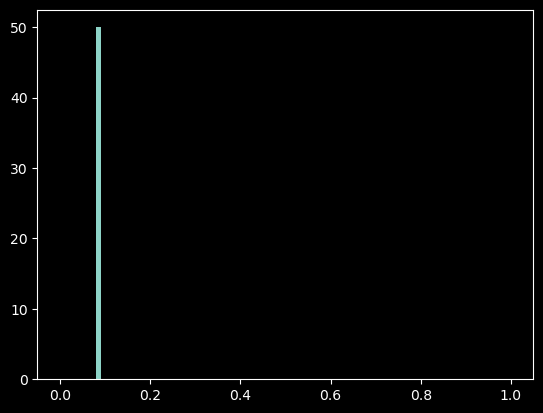

Mean loss is 2.306838035583496


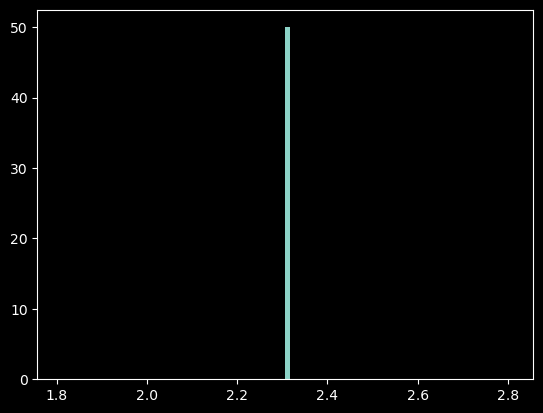

In [11]:
print("Mean accuracy is", np.mean(accuracies))
plt.hist(accuracies, range=(0,1), bins=100)
plt.show()
print("Mean loss is", np.mean(losses))
plt.hist(losses, bins=100)
plt.show()

In [12]:
# Since we want to experiment with multiple networks, we abstract the training process such that you can
# easily run training as a function.
log_basedir = os.path.join("logs", "mnist_dense/")

def train(model, x_train, y_train, epochs=20, batch_size=250, log_basedir=log_basedir):
    # Callbacks: What should be done during (long) training?

    # Function to store model to file, if validation loss has a new record
    # Check always after having seen at least another save_freq examples.
    model_file_name = model.name + '.keras'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_file_name,
        save_weights_only=False,  # save the entire model, not only the weights. This allows re-building the whole model
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1)

    # Function to decrease learning rate by 'factor'
    # when there has been no significant improvement in the last 'patience' epochs.
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', mode='min', factor=0.75, patience=3, verbose=1)

    # Use tensorboard to show the progress. See cell below for instructions on how to use tensorboard
    log_dir = log_basedir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "-" + model.name

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir,
        histogram_freq=1,  # frequency (in epochs) at which to compute activation and weight histograms for the layers
        write_images=False,  # whether to write model weights to visualize as image in TensorBoard.
    )
                         
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[checkpoint, reduce_lr, tensorboard_callback]
                       )
    return history

In [13]:
# Let us initiate the training process
history = train(model, x_train, y_train, epochs=60)

Epoch 1/60
206/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6946 - loss: 37.2550
Epoch 1: val_loss improved from inf to 5.74137, saving model to mnist_dense_solution.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7007 - loss: 36.1877 - val_accuracy: 0.8823 - val_loss: 5.7414 - learning_rate: 0.0010
Epoch 2/60
210/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 6.4687
Epoch 2: val_loss improved from 5.74137 to 4.53437, saving model to mnist_dense_solution.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 6.4617 - val_accuracy: 0.8977 - val_loss: 4.5344 - learning_rate: 0.0010
Epoch 3/60
214/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 4.9931
Epoch 3: val_loss improved from 4.53437 to 4.40016, saving model to mnist_dense_solution.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8803 - loss: 4.9888 - val_accuracy: 0.8818 - val_loss: 4.4002 - learning_rate: 0.0010
Epoch 4/60
195/216 ━━━━━━━━━━━━━━━━━

## Investigating model training history
model.fit() returned an object containing the training history. Run below cell to plot the training history in terms of loss and accuracy metrics for the training history. However, you may want to compare the actual performance and convergence characteristics with previous runs. [TensorBoard](https://www.tensorflow.org/tensorboard) is a tool for providing the measurements and visualizations needed during the machine learning workflow. Besides tracking experiment metrics like loss and accuracy it allows visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

**Notes:**
* Use the "update" button on the tensorboard extension (top right) if you have trained a new model
* The jupyter tensorboard-plugin may not give you the best overview. Run '''tensorboard --logdir your/log/directory''' in a terminal to open tensorboard in its own tab.

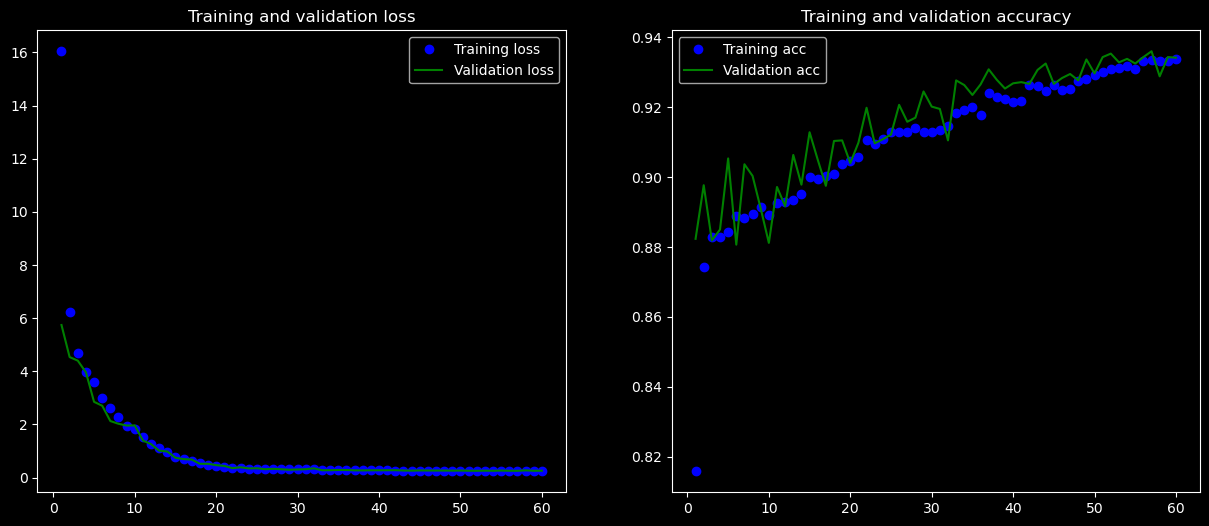

In [14]:
# plot the training history as loss and accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

_, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].plot(epochs, loss, 'bo', label='Training loss')
ax[0].plot(epochs, val_loss, 'g', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'g', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].legend();

In [15]:
%load_ext tensorboard
%tensorboard --logdir $log_basedir  # start tensorboard with ipython magic command

## Evaluation after Training

In [17]:
# Load the model and parameters with the best validation accuracy during training.
# This works also if you interruped the training!
model = tf.keras.models.load_model(model.name + '.keras')
# Note: You can also load ONLY the parameters of the model from file if you still have the model in working memory.
# model.load_weights(model.name + '.h5')
# When saving the model, you can experiment with models in the code and come back to old models.
model.summary()
print(model.optimizer.get_config())  # plot the compilation settings

Model: "mnist_dense_solution"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,282 (465.95 KB)

 Trainable params: 39,760 (155.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 79,522 (310.64 KB)

{'name': 'adam', 'learning_rate': 0.00017797850887291133, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [18]:
# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

Loss on test set: 0.30691078305244446
Accuracy on test set: 0.9218000173568726


# Hyperparameter optimization
The results you should have so far are probably not so impressive yet. The performance you have right now is roughly what networks of the late 90s were able to do. Neural networks have made tremendous progress in the last years. We will now get a sense of the methods leading to this progress step by step.

**Exercise:**

4. Modify the model and inspect the effect on the accuracy while keeping the number of weights below 100000.
Suggested modifications:
    * non-linear [activation functions](https://keras.io/api/layers/activations/). Generically discuss the pros and cons of different activation functions (later in the protocol). After choosing an activation function use the non-linear function in all further experiments.
    * [Batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization),  [theory introduction:](https://arxiv.org/pdf/1502.03167.pdf). After seeing the impact of batch normlalization use batch normalization in all further experiments.
    * number of dense layers
    * number of neurons per layer

Try to get the accuracy over at least 0.97.

In [19]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_relu")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

Model: "mnist_dense_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,760 (155.31 KB)

 Trainable params: 39,760 (155.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
205/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5845 - loss: 21.1723
Epoch 1: val_loss improved from inf to 1.08524, saving model to mnist_dense_relu.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5884 - loss: 20.3971 - val_accuracy: 0.7197 - val_loss: 1.0852 - learning_rate: 0.0010
Epoch 2/20
194/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7319 - loss: 1.0832
Epoch 2: val_loss improved from 1.08524 to 0.73402, saving model to mnist_dense_relu.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7341 - loss: 1.0770 - val_accuracy: 0.8210 - val_loss: 0.7340 - learning_rate: 0.0010
Epoch 3/20
200/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8122 - loss: 0.7714
Epoch 3: val_loss improved from 0.73402 to 0.59139, saving model to mnist_dense_relu.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.7703 - val_accuracy: 0.8582 - val_loss: 0.5914 - learning_rate: 0.0010
Epoch 4/20
206/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

In [20]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_sigmoid")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.Dense(50, activation='sigmoid'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

Model: "mnist_dense_sigmoid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,760 (155.31 KB)

 Trainable params: 39,760 (155.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
205/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5702 - loss: 1.4855
Epoch 1: val_loss improved from inf to 0.49089, saving model to mnist_dense_sigmoid.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5793 - loss: 1.4603 - val_accuracy: 0.8950 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 2/20
202/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.5134
Epoch 2: val_loss improved from 0.49089 to 0.36032, saving model to mnist_dense_sigmoid.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.5107 - val_accuracy: 0.9052 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 3/20
201/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8942 - loss: 0.3937
Epoch 3: val_loss improved from 0.36032 to 0.29599, saving model to mnist_dense_sigmoid.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8944 - loss: 0.3926 - val_accuracy: 0.9200 - val_loss: 0.2960 - learning_rate: 0.0010
Epoch 4/20
190/216 ━━━━━━━━━━━━━━━━━━━━ 0

In [21]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_tanh")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.Dense(50, activation='tanh'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

Model: "mnist_dense_tanh"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,760 (155.31 KB)

 Trainable params: 39,760 (155.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-10-29 11:52:53.229382: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_213', 4 bytes spill stores, 8 bytes spill loads



193/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4952 - loss: 1.6050
Epoch 1: val_loss improved from inf to 0.51921, saving model to mnist_dense_tanh.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5159 - loss: 1.5437 - val_accuracy: 0.8643 - val_loss: 0.5192 - learning_rate: 0.0010
Epoch 2/20
204/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8435 - loss: 0.5411
Epoch 2: val_loss improved from 0.51921 to 0.37359, saving model to mnist_dense_tanh.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8439 - loss: 0.5391 - val_accuracy: 0.8955 - val_loss: 0.3736 - learning_rate: 0.0010
Epoch 3/20
193/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.4189
Epoch 3: val_loss improved from 0.37359 to 0.33558, saving model to mnist_dense_tanh.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8772 - loss: 0.4185 - val_accuracy: 0.9080 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 4/20
211/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accurac

In [22]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_swish")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.Dense(50, activation='swish'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

Model: "mnist_dense_swish"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,760 (155.31 KB)

 Trainable params: 39,760 (155.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
202/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5243 - loss: 27.1064    
Epoch 1: val_loss improved from inf to 1.19602, saving model to mnist_dense_swish.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5294 - loss: 25.8107 - val_accuracy: 0.7090 - val_loss: 1.1960 - learning_rate: 0.0010
Epoch 2/20
199/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7092 - loss: 1.1954
Epoch 2: val_loss improved from 1.19602 to 0.83810, saving model to mnist_dense_swish.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7116 - loss: 1.1879 - val_accuracy: 0.8173 - val_loss: 0.8381 - learning_rate: 0.0010
Epoch 3/20
204/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.8388
Epoch 3: val_loss improved from 0.83810 to 0.64293, saving model to mnist_dense_swish.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8018 - loss: 0.8366 - val_accuracy: 0.8637 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 4/20
205/216 ━━━━━━━━━━━━━━━━━━━━ 0

In [23]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_normalization")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

Model: "mnist_dense_normalization"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,896 (167.56 KB)

 Trainable params: 41,328 (161.44 KB)

 Non-trainable params: 1,568 (6.12 KB)

Epoch 1/20
214/216 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7457 - loss: 0.8297
Epoch 1: val_loss improved from inf to 0.20404, saving model to mnist_dense_normalization.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7473 - loss: 0.8245 - val_accuracy: 0.9470 - val_loss: 0.2040 - learning_rate: 0.0010
Epoch 2/20
211/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9419 - loss: 0.2017
Epoch 2: val_loss improved from 0.20404 to 0.17334, saving model to mnist_dense_normalization.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9420 - loss: 0.2014 - val_accuracy: 0.9575 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 3/20
202/216 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9577 - loss: 0.1469
Epoch 3: val_loss improved from 0.17334 to 0.16482, saving model to mnist_dense_normalization.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9577 - loss: 0.1467 - val_accuracy: 0.9627 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 4/20
203/216 ━━━━

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_layers2")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_layers3")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_units150x50")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(150, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_units50x20")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(20, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_units100x50")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(100, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_units200x50")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(200, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_units300x50")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(300, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [ ]:
# Suggestion/Solution for last task
model = tf.keras.models.Sequential(name="mnist_dense_units250x50")  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(300, activation='relu'))
model.add( tf.keras.layers.Dense(50, activation='relu'))
model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

# pretty print a summary of the layer types and dimensions
model.summary()


history = train(model, x_train, y_train)

# Evaluate the performance of the network on an indepdendent test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss on test set:", test_loss)
print("Accuracy on test set:", test_acc)

In [24]:
def build_model(i: int):
    # Suggestion/Solution for last task
    model = tf.keras.models.Sequential(name=f"mnist_dense_units250x50_run_{i}")  # sequential stack of network layers

    model.add(tf.keras.layers.Input((img_size, img_size)))
    model.add(tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Configure the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
    return model

histories = []
test_results = []
for i in range(100):
    print("-" * 20)
    print("NEW ITERATION", i)
    print("-" * 20)
    model = build_model(i)
    histories.append(train(model, x_train, y_train))
    test_results.append(model.evaluate(x_test, y_test, verbose=0))

--------------------
NEW ITERATION 0
--------------------
Epoch 1/20


2024-10-29 11:55:07.979484: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 124 bytes spill stores, 124 bytes spill loads

2024-10-29 11:55:08.083794: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_242', 180 bytes spill stores, 180 bytes spill loads



191/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8164 - loss: 0.6012
Epoch 1: val_loss improved from inf to 0.12827, saving model to mnist_dense_units250x50_run_0.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8275 - loss: 0.5652 - val_accuracy: 0.9672 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 2/20
204/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 0.1061
Epoch 2: val_loss improved from 0.12827 to 0.11559, saving model to mnist_dense_units250x50_run_0.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9675 - loss: 0.1057 - val_accuracy: 0.9715 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 3/20
205/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0613
Epoch 3: val_loss did not improve from 0.11559
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9811 - loss: 0.0613 - val_accuracy: 0.9757 - val_loss: 0.1163 - learning_rate: 0.0010
Epoch 4/20
206/216 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 

KeyboardInterrupt: 

Accuracy =  0.977278573172433 +- 0.001033853206752484


(array([2., 0., 0., 2., 1., 3., 0., 2., 2., 2.]),
 array([0.97539997, 0.97573997, 0.97607998, 0.97641998, 0.97675998,
        0.97709998, 0.97743999, 0.97777999, 0.97811999, 0.97846   ,
        0.9788    ]),
 <BarContainer object of 10 artists>)

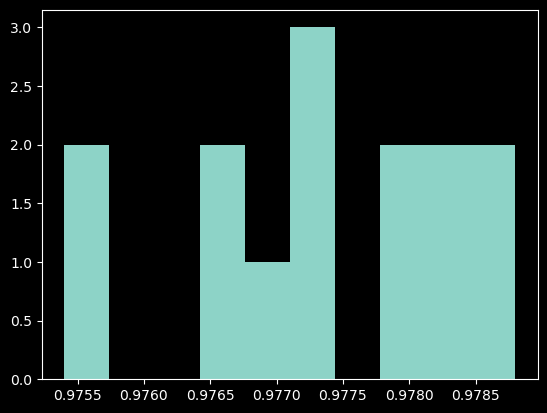

In [25]:
test_results = np.array(test_results)
print("Accuracy = ", np.mean(test_results[:, 1]), "+-", np.sqrt(np.var(test_results[:, 1])))
plt.hist(test_results[:, 1])

## Summary
In general you see, that linear activation converges much slower but you can actually learn a decent amount already with that.
Non linear activation however improves final performance and learning speed significantly *[1 point]*. Relu is a good choice often so we propose to stick with that.
Batch normalization adds a huge amount of stability to the training process so this is a good choice by default *[1 point]*.
A bit of depth can help *[1 point]*.
Further hyperparameter optimization is often tricky to do manually. Practical Recommendations for Gradient-Based Training of neural networks can be found [here](https://arxiv.org/pdf/1206.5533v2.pdf).
*[Up to 2 points for clever hyperparameter choice or even optimization]*